---
### Setup
* create a virtual environment
* run `pip install jupyter`
* Set Up Jupyter Kernel: `python -m ipykernel install --user --name=venv --display-name "data-analysis (venv)"
* Select this kernel

In [7]:
# Copy the data out files from the raspberry pi to the data folder with a shell command - SH: command not tested! 
# !scp pi@lohast-IPAdresss:/root/presist/overlay/data/out /data/out

---
## Notebook for `berries` power analysis of all 

---
### Read Data: Read the Data from the `data` folder into the `data_dict` variable
* Reads the data from the `data/out` directory
* Saves the data to the `data_dict` variable

In [8]:
import os
import pandas as pd
from fontTools.misc.bezierTools import approximateQuadraticArcLength

SERVICES  = ['rust-actix', 'rust-actix-synchronized-orm', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'python-flask-one-thread', 'c-sharp-razor', 'javascript-express', 'javascript-express-bun'] # 'python-flask', 'go-gorilla', 
base_dir = 'data/out'
dir_out = 'plots/'
data_dict = {}

for service in SERVICES:
    
    service_dir = os.path.join(base_dir, service, 'berries')
    if not os.path.exists(service_dir):
        print(f"Directory does not exist: {service_dir}")
        continue
        
    # iterates of files in service_dir    
    for file_name in os.listdir(service_dir):
        file_path = os.path.join(service_dir, file_name)
            
        # Read the CSV files based on their naming convention
        if file_name.endswith(".csv"):
            if "power" in file_name:
                df_power = pd.read_csv(file_path, sep=',', quotechar='"', on_bad_lines='skip')
                # df_power = df_power[~df_power['iteration'].isin([0, 29])]
                
                # Calculate timedelta and energy for each row
                grouped = df_power.groupby('iteration')
                df_power['timedelta'] = grouped['timestamp'].diff()
                df_power['timedelta'] = df_power['timedelta'].fillna(0)
                df_power['energy'] = grouped.apply(
                    lambda group: group['power'] * group['timedelta']
                ).reset_index(level=0, drop=True)
                df_power['energy'] = df_power['energy'].fillna(0)
                
                # Calculate cumulative energy per iteration
                df_power['cumulative_energy'] = grouped['energy'].cumsum()
                
                # Create timedelta index
                df_power['timedelta_index'] = df_power.groupby('iteration')['timestamp'].diff().fillna(0).cumsum()
                df_power.set_index('timedelta_index', inplace=True)
                df_power.sort_index(inplace=True)

                # Store DataFrame in data_dict
                data_dict[service] = df_power
            else:
                print("dataframe power does not exist")
                
# discard iteration 0 
for service in SERVICES:
    data_dict[service] = data_dict[service][data_dict[service]['iteration'] != 0]


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/2572888928.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_power['energy'] = grouped.apply(
/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/2572888928.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_power['energy'] = grouped.apply(
/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/2572888928.py:3

In [9]:
# Filter the DataFrame for rows where iteration is 1 or 2
df_ruby_sinatra = data_dict['ruby-sinatra']
filtered_df = df_ruby_sinatra[df_ruby_sinatra['iteration'].isin([1, 2])]

# Sort by timedelta_index to ensure the rows are ordered correctly
filtered_df = filtered_df.sort_index()

# Display rows around the transition from iteration 1 to 2
transition_rows = filtered_df[filtered_df['iteration'].diff() == 1]

print("Rows where iteration transitions from 1 to 2:")
print(transition_rows)

# Display the surrounding rows (for context)
print("\nContext around the transition:")
context_rows = filtered_df.loc[transition_rows.index[0] - 2:transition_rows.index[0] + 2]
print(context_rows)

Rows where iteration transitions from 1 to 2:
                    timestamp     power   current   voltage  iteration  \
timedelta_index                                                          
72.9488          1.734181e+09  3.161039  0.632252  4.999657          2   

                 timedelta  energy  cumulative_energy  
timedelta_index                                        
72.9488                0.0     0.0                0.0  

Context around the transition:
                    timestamp     power   current   voltage  iteration  \
timedelta_index                                                          
70.9488          1.734181e+09  2.980871  0.596194  4.999829          1   
70.9489          1.734181e+09  2.984866  0.596952  5.000174          1   
70.9490          1.734181e+09  2.986495  0.597256  5.000361          1   
70.9491          1.734181e+09  2.983957  0.596764  5.000229          1   
70.9492          1.734181e+09  2.983623  0.596694  5.000253          1   
...          

In [10]:
# check applications in data_dict
print("applications in data_dict:")
print(data_dict.keys())
print("dataframe:")
data_dict['ruby-sinatra'][data_dict['ruby-sinatra']['iteration'] == 2]

# Energy accumulated over time

applications in data_dict:
dict_keys(['rust-actix', 'rust-actix-synchronized-orm', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'python-flask-one-thread', 'c-sharp-razor', 'javascript-express', 'javascript-express-bun'])
dataframe:


,timestamp,power,current,voltage,iteration,timedelta,energy,cumulative_energy
timedelta_index,,,,,,,,
72.9488,1.734181e+09,3.161039,0.632252,4.999657,2,0.0000,0.000000,0.000000
72.9489,1.734181e+09,3.087111,0.617391,5.000253,2,0.0001,0.000309,0.000309
72.9490,1.734181e+09,3.051762,0.610340,5.000100,2,0.0001,0.000305,0.000614
72.9491,1.734181e+09,3.036126,0.607188,5.000305,2,0.0001,0.000304,0.000918
72.9492,1.734181e+09,3.027349,0.605469,5.000011,2,0.0001,0.000302,0.001220
...,...,...,...,...,...,...,...,...
108.6543,1.734181e+09,3.003921,0.600828,4.999648,2,0.0001,0.000301,111.235961
108.6544,1.734181e+09,3.081014,0.616154,5.000399,2,0.0001,0.000308,111.236269
108.6545,1.734181e+09,3.012960,0.602522,5.000583,2,0.0001,0.000302,111.236570


---
### Helper functions for data pipline sequential analysis

In [11]:
from datetime import datetime

# Helper functions for data pipline sequential analysis

def customize_boxplot(bplot, colors, tick_color, median_color):
    """
    Helper function to customize the appearance
    """
    # Customize the box colors
    for patch, color in zip(bplot['boxes'], colors):
        patch.set(color=color, linewidth=1.5)  # Set box outline color and line width
        patch.set(facecolor=color, alpha=0.8)  # Fill the box with the specified color

    # Customize the whiskers
    for whisker in bplot['whiskers']:
        whisker.set(color=tick_color, linewidth=1.5)  # Set whisker color and line width

    # Customize the caps
    for cap in bplot['caps']:
        cap.set(color=tick_color, linewidth=1.5)  # Set cap color and line width

    # Customize the medians
    for median in bplot['medians']:
        median.set(color=median_color, linewidth=1.5)  # Set median line color
        
        
def save_plot(fig, weact_service, plot_type="sequential", filename_suffix="energy"):
    """
    Save a plot to a specific directory with a timestamped filename.
    """
    vector_format="pdf"
    if plot_type == "compare-berries":
        dir_out = f'plots/{plot_type}'
    else:
        dir_out = f'plots/{weact_service}/{plot_type}'
        
    current_time = datetime.now().strftime("%Y-%m-%d_%H:%M")  # Format: YYYY-MM-DD_HH
    # Create the directory if it doesn't exist
    os.makedirs(dir_out, exist_ok=True)
    
    # Save the figure
    fig.savefig(
        os.path.join(dir_out, f"{weact_service}_{filename_suffix}_{current_time}.{vector_format}"),
        bbox_inches='tight',
        dpi=150,
        facecolor='white'
    )
    print(f"Plot for {weact_service} ({plot_type}) saved as {filename_suffix} at {dir_out}")
    

def define_title_xlable_ylable_line_chart(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    """
    if analyse == 'power':
        title = 'Power Consumption by Language & Framework'
        y_label = 'Power (W)'
    elif analyse == 'delta':
        title = 'Execution Time by Language & Framework'
        y_label = 'Time (s)'
    elif 'cumulative_energy':
        title = 'Energy Spent Over Time by Language & Framework'
        y_label = 'Energy (J)'
    else:
        print("No valid metric defined")
    x_label = 'Time (s)'
    return title, x_label, y_label

def define_title_xlable_ylable_boxplot(analyse):
    """
    Define title, x-label and y-label based on the comparison of
    """
    if analyse == 'power':
        title = 'Power Consumption by by Language & Framework'
        y_label = 'Power (W)'
    elif analyse == 'running_time':
        title = 'Execution Time by Language & Framework'
        y_label = 'Time (s)'
    elif analyse == 'energy':
        title = 'Energy by Language & Framework'
        y_label = 'Energy (J)'
    x_label = 'Language & Framework'
    return title, x_label, y_label


flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 2,
        'linestyle': 'none',
        'alpha': 0.2,
}

---
### Line Chart: Power Consumption Over Time for a Single Application Run

* This step plots a single application run's power consumption over time.
* plots the defined metric for all endpoints for a single service


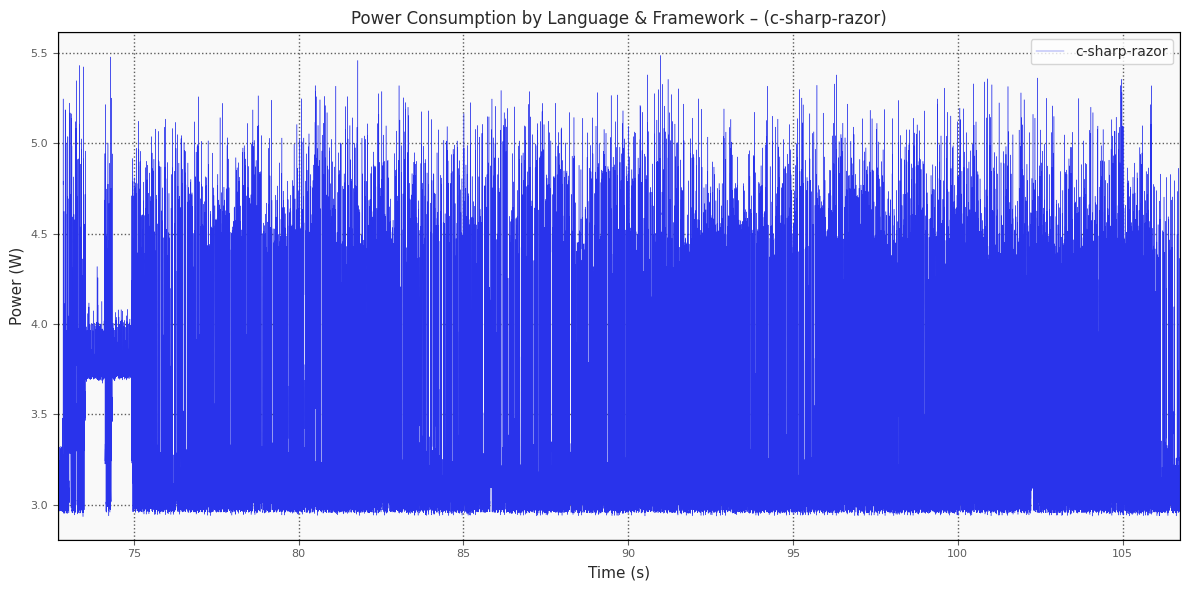

In [12]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

waect_service = 'c-sharp-razor' # define service to be ploted
metric = 'power' # define metric to be ploted `power` and `energy`
df = data_dict[waect_service][data_dict[waect_service]['itera tion'] == 2]

# settings for this plot
labels_fontsize = 11
labels_fontcolor = "#2A2A2A"
title_fontsize = 12
tick_color = "#5D5D5D"

# Plot single run power consumption
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
fig.patch.set_facecolor('#FFFFFF') 
ax.set_facecolor('#F9F9F9')

ax.plot(
    df.index,
    df[metric],
    linewidth=0.3,
    color='#2933EB'
)

# only if cumulative energy is polotted
if metric == 'cumulative_energy':
    ax.fill_between(
        df.index,
        df[metric],
        color='#2933EB',
        alpha=0.3 
    )
    
# Set title and labels
title, x_label, y_label = define_title_xlable_ylable_line_chart(metric)

ax.grid(True, linestyle='dotted', linewidth=1, color=tick_color)  # Setting custom grid color
ax.set_title(f'{title} – ({waect_service})', color=labels_fontcolor, fontsize=title_fontsize)  # Set an appropriate title
ax.set_xlabel(f"{x_label}", color=labels_fontcolor, fontsize=labels_fontsize,)  # Set an appropriate label for the x-axis
ax.set_ylabel(f"{y_label}", color=labels_fontcolor, fontsize=labels_fontsize)  # Label for the y-axis
ax.tick_params(labelsize=8, color=tick_color, labelcolor=tick_color)
ax.autoscale(enable=True, axis="x", tight=True)

border = Rectangle(
    (0, 0), 1, 1,
    transform=ax.transAxes,
    facecolor='none',
    edgecolor=tick_color,
    linewidth=1.0  
)

ax.add_patch(border)
    
ax.legend([waect_service], loc='upper right', fontsize=10, labelcolor=labels_fontcolor,facecolor="white", framealpha=0.8)
plt.tight_layout()
plt.show()

In [13]:
# Save the plot
save_plot(fig, waect_service, "berries", metric)

Plot for c-sharp-razor (berries) saved as power at plots/c-sharp-razor/berries


---
### Line Chart: Power Consumption Over Time for two applications runs

In [14]:
reindexed_data_dict = {}

SERVICES = ['rust-actix', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'c-sharp-razor', 'javascript-express'] # Define the services to compare

# Determine the union of all timedelta_index values across the services
all_timedelta_indices = set()
for service in SERVICES:
    original_df = data_dict[service]
    iteration_1_df = original_df[original_df['iteration'] == 1].copy()  # choose only index 1
    reindexed_data_dict[service] = iteration_1_df
    all_timedelta_indices.update(reindexed_data_dict[service].index)
    
# Create a sorted list of all unique indices
all_timedelta_indices = sorted(all_timedelta_indices)

# Reindex each DataFrame to match the union of all timedelta_index values
for service in SERVICES:
    reindexed_data_dict[service] = reindexed_data_dict[service].reindex(all_timedelta_indices)

# Check the lengths of the DataFrames to confirm they are now the same
for service in SERVICES:
    print(f"{service} length: {len(reindexed_data_dict[service])}")
    

rust-actix length: 1056812
ruby-sinatra length: 1056812
go-gorilla length: 1056812
go-gin length: 1056812
python-flask length: 1056812
c-sharp-razor length: 1056812
javascript-express length: 1056812


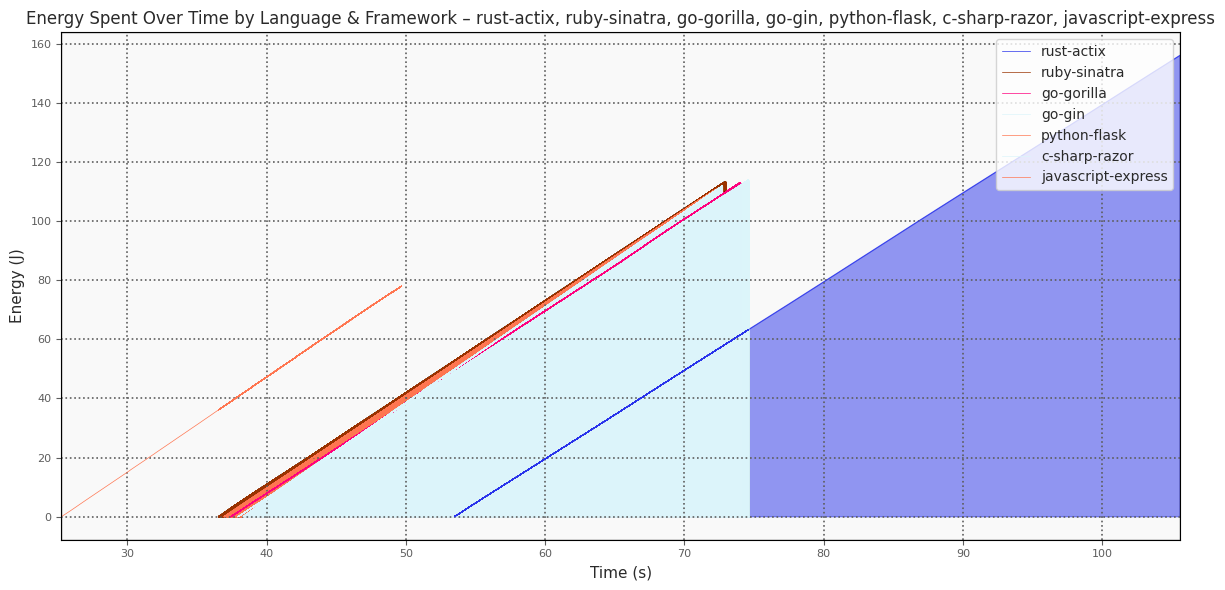

In [15]:
metric = 'cumulative_energy'  # Define the metric to compare - possible: 'power' & 'cumulative_energy'

# Plot cumulative energy consumption for both services
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
fig.patch.set_facecolor('#FFFFFF')
ax.set_facecolor('#F9F9F9')

# Define colors for each service
colors = ['#2933EB', '#993200', '#FF007E', '#DCF5FB', '#FF7651', '#DCF5FB', '#FF7651']  # Blue for python-flask, Brown for go-gorilla
alphas = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0,5]  # Transparency for filled areas

# determine line alpha based on metric
if metric == 'power':
    line_alpha = 0.65
else:  
    line_alpha = 1.0

# Plotting cumulative energy with fill_between
for i, service in enumerate(SERVICES):
    filtered_data = reindexed_data_dict[service] # [data_dict[service]['iteration'] == 2]
    ax.plot(
        filtered_data.index,
        filtered_data[metric],
        linewidth=0.5,
        color=colors[i],
        label=service,
        alpha=line_alpha
    )
    if metric == 'cumulative_energy':
        ax.fill_between(
            filtered_data.index,
            filtered_data[metric],
            color=colors[i],
            alpha=alphas[i]
        )
        
# Customize grid, labels, etc.
ax.grid(True, linestyle='dotted', linewidth=1.2, color=tick_color)
title, x_label, y_label = define_title_xlable_ylable_line_chart(metric)
ax.set_title(f'{title} – {", ".join(SERVICES)}', color=labels_fontcolor, fontsize=title_fontsize)
ax.set_xlabel(f"{x_label}", color=labels_fontcolor, fontsize=labels_fontsize)
ax.set_ylabel(f"{y_label}", color=labels_fontcolor, fontsize=labels_fontsize)
ax.tick_params(labelsize=8, color=tick_color, labelcolor=tick_color)
ax.autoscale(enable=True, axis="x", tight=True)

# Adding a border around the plot area (axes)
border = Rectangle(
    (0, 0), 1, 1,
    transform=ax.transAxes,
    facecolor='none',
    edgecolor=tick_color,
    linewidth=1
)
ax.add_patch(border)

# Add legend to distinguish between the services
ax.legend(loc='upper right', fontsize=10, labelcolor=labels_fontcolor, facecolor="white", framealpha=0.8)

plt.tight_layout()
plt.show()

In [16]:
# Save the plot
save_plot(fig, f'{"_".join(SERVICES)}_line_chart', plot_type="compare-berries", filename_suffix=metric)

Plot for rust-actix_ruby-sinatra_go-gorilla_go-gin_python-flask_c-sharp-razor_javascript-express_line_chart (compare-berries) saved as cumulative_energy at plots/compare-berries


---
### Boxplot: Boxplot for Power Consumption Comparison Across Applications

* plots a boxplot for power consumption comparison across applications.
* Define the services to compare 
* Define the metric to analyse `power`, `delta`, `energy`

In [17]:
data_dict['rust-actix'].head()

,timestamp,power,current,voltage,iteration,timedelta,energy,cumulative_energy
timedelta_index,,,,,,,,
53.4879,1.734171e+09,2.962494,0.592464,5.000293,1,0.0000,0.000000,0.000000
53.4880,1.734171e+09,2.963493,0.592664,5.000295,1,0.0001,0.000297,0.000297
53.4881,1.734171e+09,2.962789,0.592543,5.000122,1,0.0001,0.000296,0.000593
53.4882,1.734171e+09,2.962193,0.592417,5.000179,1,0.0001,0.000297,0.000889
53.4883,1.734171e+09,2.961320,0.592266,4.999982,1,0.0001,0.000296,0.001185


In [18]:
# Define services and endpoints
def plot_application_comparison(data_dict, applications, metric='energy', group_colors=None, median_color="#EB4532"):
    """
    Plot a comparison of services based on a specific metric using box plots.

    Parameters:
    - data_dict (dict): A dictionary where keys are service names and values are their data as DataFrames.
    - services (list): List of services to compare.
    - metric (str): The metric to use for comparison ('energy', 'running_time', etc.).
    - group_colors (list): List of colors to alternate between for the box plots.
    - median_color (str): Color for the median lines in the box plots.
    """
    grouped_data = []
    labels = []
    group_colors = ['#2933EB', '#2933EB']
    median_color = "#EB4532"
    
    for service in applications:
        # grouping 
        df_service = data_dict[service]
        if metric == 'energy':
            service_metric_data = df_service.groupby('iteration')['cumulative_energy'].last()
        elif metric == 'running_time':
            service_metric_data = df_service.groupby('iteration').apply(lambda group: group['timestamp'].iloc[-1] - group['timestamp'].iloc[0])
        else:
            service_metric_data = df_service[metric].dropna() 
        grouped_data.append(service_metric_data)
        labels.append(service)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(6, 8), facecolor='white')
    ax.set_facecolor('#F9F9F9')
    
    flierprops = {
        'marker': 'o',
        'markerfacecolor': '#D7B0FF',
        'markeredgecolor': '#978AB5',
        'markersize': 5,
        'alpha': 0.4,
    }   
    
    # Box plot
    bplot = ax.boxplot(
        grouped_data,
        patch_artist=True,
        widths=0.6,
        labels=labels,
        flierprops=flierprops
    )
    
    for i, patch in enumerate(bplot['boxes']):
        patch.set(facecolor=group_colors[i % 2], alpha=0.8)  # Alternate colors for services
        patch.set(color=group_colors[i % 2], linewidth=1.2)
        patch.set(linewidth=1.2)  # Set border width
        
    customize_boxplot(bplot, group_colors, tick_color, median_color)
    
    # Set title and labels
    title, x_label, y_label = define_title_xlable_ylable_boxplot(metric)
    ax.set_title(f'{title}', color=labels_fontcolor, fontsize=title_fontsize)
    ax.set_ylabel(f'{y_label}', color=labels_fontcolor, fontsize=labels_fontsize)
    ax.set_xlabel(f'{x_label}', color=labels_fontcolor, fontsize=labels_fontsize)
    
    # Customize tick labels
    ax.tick_params(axis='x', labelsize=10, rotation=22.5, labelcolor='#5D5D5D')
    ax.tick_params(axis='y', labelsize=10, labelcolor='#5D5D5D')
    ax.grid(True, linestyle='dotted', linewidth=1.0, color=tick_color)
    
    # Add legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.8) for color in group_colors]
    # ax.legend(handles, legend_labels, loc='upper right', fontsize=10)
    
    # Optional set y-axis limits for better visualization
    # ax.set_ylim(2.8, 3.5)
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    return fig


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/893557241.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


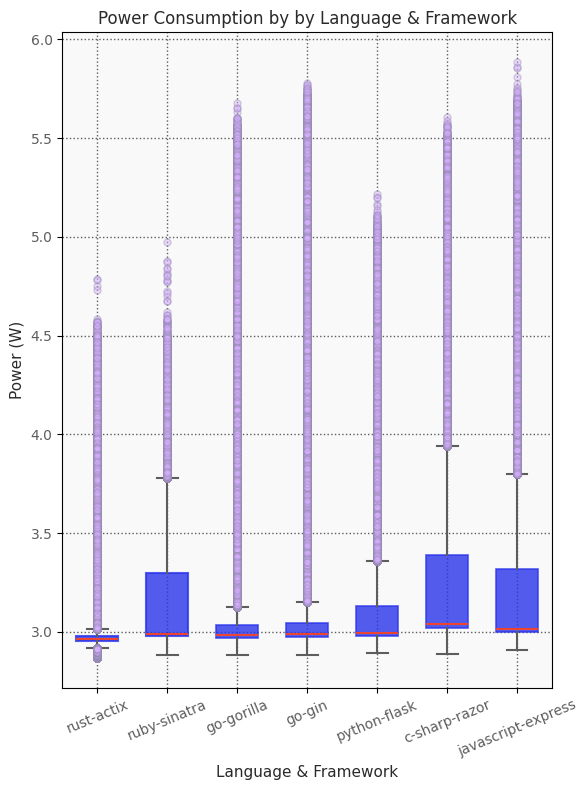

In [19]:
# plot results power
applications = ['rust-actix', 'ruby-sinatra', 'go-gorilla', 'go-gin', 'python-flask', 'c-sharp-razor', 'javascript-express']
metric = 'power'
fig = plot_application_comparison(
        data_dict=data_dict,
        applications=applications,
        metric=metric
        )

In [20]:
# save results power
save_plot(fig, f'{"_".join(applications)}_boxplot', plot_type="compare-berries", filename_suffix=metric)

Plot for rust-actix_ruby-sinatra_go-gorilla_go-gin_python-flask_c-sharp-razor_javascript-express_boxplot (compare-berries) saved as power at plots/compare-berries


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/893557241.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  service_metric_data = df_service.groupby('iteration').apply(lambda group: group['timestamp'].iloc[-1] - group['timestamp'].iloc[0])
/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/893557241.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  service_metric_data = 

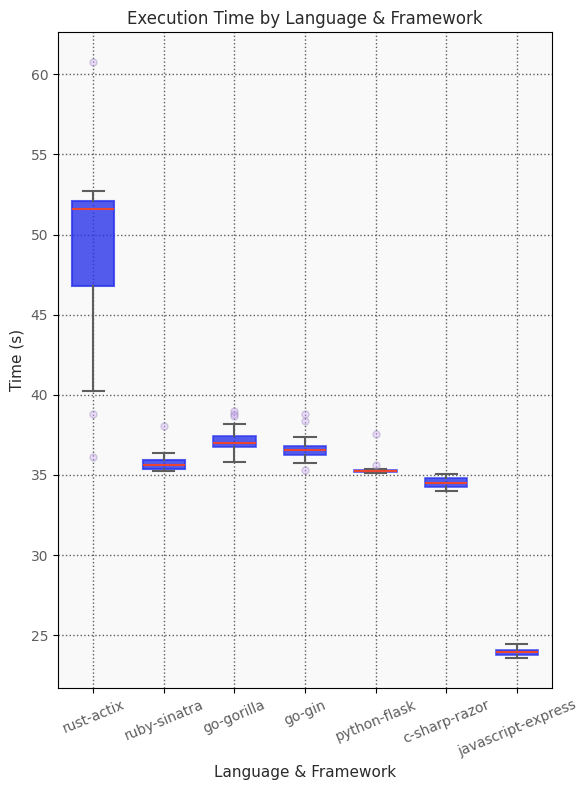

In [21]:
# plot results running time
metric = 'running_time'
fig = plot_application_comparison(
        data_dict=data_dict,
        applications=applications,
        metric=metric
        )

In [22]:
# save results running time
save_plot(fig, f'{"_".join(applications)}_boxplot', plot_type="compare-berries", filename_suffix=metric)

Plot for rust-actix_ruby-sinatra_go-gorilla_go-gin_python-flask_c-sharp-razor_javascript-express_boxplot (compare-berries) saved as running_time at plots/compare-berries


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/893557241.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


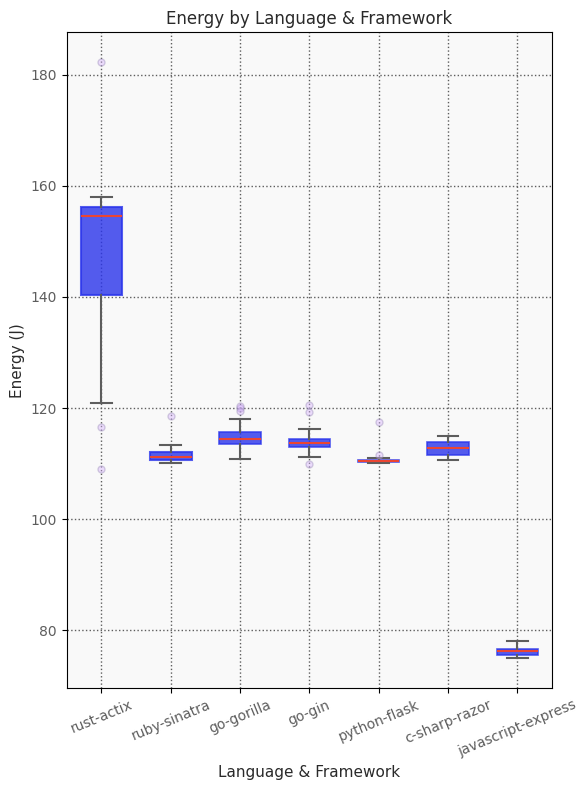

In [23]:
# plot results energy
metric = 'energy'
fig = plot_application_comparison(
        data_dict=data_dict,
        applications=applications,
        metric=metric
        )

In [24]:
# save the energy consumption
save_plot(fig, f'{"_".join(applications)}_boxplot', plot_type="compare-berries", filename_suffix=metric)

Plot for rust-actix_ruby-sinatra_go-gorilla_go-gin_python-flask_c-sharp-razor_javascript-express_boxplot (compare-berries) saved as energy at plots/compare-berries


/var/folders/gb/tnf1yptj0gl7g0718ztgp6340000gn/T/ipykernel_32306/893557241.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = ax.boxplot(


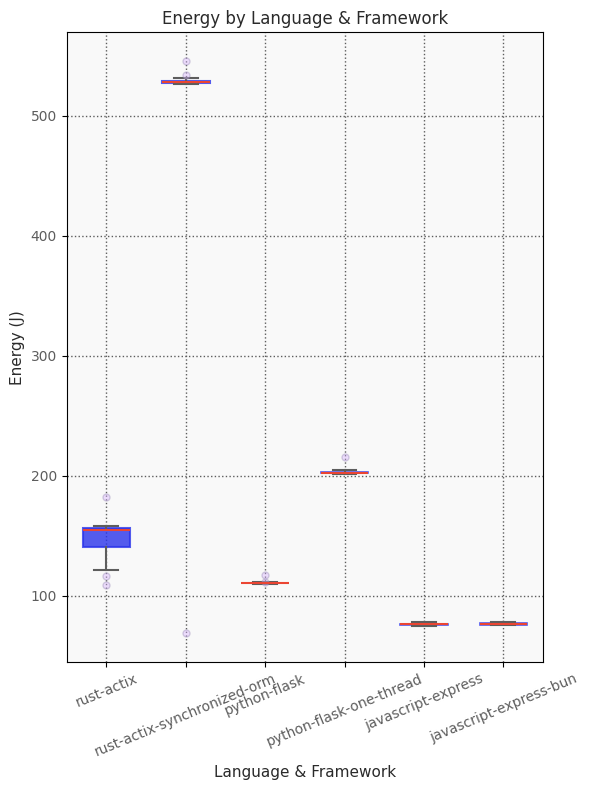

In [30]:
# special cases: 
applications = ['rust-actix', 'rust-actix-synchronized-orm', 'python-flask', 'python-flask-one-thread', 'javascript-express', 'javascript-express-bun']
metric = 'energy'
fig = plot_application_comparison(
        data_dict=data_dict,
        applications=applications,
        metric=metric
        )

---
### Table: Final Energy Consumption for Each Application
* Calculate the final energy consumption for each application all metrics
* calculte min, q1, median, q3, max, arithmetic mean, std

In [26]:
# calculate min, q1, median, q3, max, arithmetic mean, std
final_results = {}

for service in SERVICES:
    # Extract cumulative_energy for the last value in each iteration
    df_service = data_dict[service]
    final_energy = df_service.groupby('iteration')['cumulative_energy'].last()

    # Calculate the required statistics
    statistics = {
        "min (q0)": final_energy.min(),
        "q1": final_energy.quantile(0.25),
        "median (q2)": final_energy.median(),
        "q3": final_energy.quantile(0.75),
        "max (q4)": final_energy.max(),
        "mean (μ)": final_energy.mean(),
        "std (σ)": final_energy.std(),
    }
    final_results[service] = statistics

final_results_df = pd.DataFrame(final_results)
print(final_results_df)
    

             rust-actix  ruby-sinatra  go-gorilla      go-gin  python-flask  \
min (q0)     108.983646    110.199775  110.833087  109.914528    110.049831   
q1           140.399539    110.606618  113.553332  112.917668    110.312462   
median (q2)  154.609509    111.279467  114.357943  113.774909    110.497362   
q3           156.184634    112.059958  115.682728  114.374800    110.648752   
max (q4)     182.269106    118.548453  120.444120  120.627965    117.468346   
mean (μ)     148.900131    111.636879  114.991766  114.054294    110.741563   
std (σ)       14.714510      1.606230    2.274843    2.145450      1.332420   

             c-sharp-razor  javascript-express  
min (q0)        110.651729           74.940235  
q1              111.541896           75.543196  
median (q2)     112.843309           76.230813  
q3              113.871599           76.639983  
max (q4)        115.034214           78.042097  
mean (μ)        112.755070           76.168583  
std (σ)           1.2663

---
### Confidence Interval: Power Consumption Comparison Across Applications

In [27]:
from scipy.stats import t

df_application = grouped_data[3]

# Perform a confidence interval test
mean = df_application.mean()
std_dev = df_application.std()
n = len(df_application)
confidence_level = 0.9
degrees_freedom = n - 1
critical_value = t.ppf((1 + confidence_level) / 2, degrees_freedom)

# Margin of error
margin_of_error = critical_value * (std_dev / (n ** 0.5))

# Confidence Interval
lower_bound = mean - margin_of_error
upper_bound = mean + margin_of_error

print(f"Mean: {mean}")
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

NameError: name 'grouped_data' is not defined

In [76]:
import numpy as np

# Desired margin of error (e.g., 0.1, adjust as needed)
desired_margin_of_error = 0.1

# Calculate the required sample size
required_sample_size = (critical_value * std_dev / desired_margin_of_error) ** 2
required_sample_size = np.ceil(required_sample_size)  # Round up to the next whole number

print(f"Mean: {mean}")
print(f"95% Confidence Interval with current data: [{mean - margin_of_error}, {mean + margin_of_error}]")
print(f"Desired Margin of Error: {desired_margin_of_error}")
print(f"Required Sample Size (number of iterations): {required_sample_size}")

Mean: 114.05429424498594
95% Confidence Interval with current data: [113.37656361877825, 114.73202487119363]
Desired Margin of Error: 0.1
Required Sample Size (number of iterations): 1333.0


* make a good story!!!

* running os + docker 
* only the application takes - this amount!
* related work suggested - there not very close but in ours it is close 
* A real application behave not as drastic difference 

* Massage the question so we don't know what we are talking about!
* what we generate is the truth! 
* suprising result is always future work! 

* popular belelive of complied languages -
* Dreading interpraped langues -

* write down the goal of this thsis:
* Is it possible to compare them and fair? 

* Case repo pops up - keep contact! 
* Go to the first step in the direction - 